## Homework

> Note: sometimes your answer doesn't match one of the options exactly. 
> That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the Bank Marketing dataset. Download it from [here](https://archive.ics.uci.edu/static/public/222/bank+marketing.zip).

You can do it with `wget`:

```bash
wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
unzip bank+marketing.zip 
unzip bank.zip
```

We need `bank-full.csv`.

In this dataset the target variable is `y` variable - has the client subscribed a term deposit or not. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv('bank-full.csv', sep = ';')
df.shape

(45211, 17)

### Dataset preparation

For the rest of the homework, you'll need to use only these columns:

* `'age'`,
* `'job'`,
* `'marital'`,
* `'education'`,
* `'balance'`,
* `'housing'`,
* `'contact'`,
* `'day'`,
* `'month'`,
* `'duration'`,
* `'campaign'`,
* `'pdays'`,
* `'previous'`,
* `'poutcome'`,
* `'y'`



Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`


In [3]:
df = df[['age',
'job',
'marital',
'education',
'balance',
'housing',
'contact',
'day',
'month',
'duration',
'campaign',
'pdays',
'previous',
'poutcome',
'y']]
df.shape

(45211, 15)

In [4]:
df.y = (df.y == 'yes').astype(int)
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,0


In [5]:
numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical = ['job',
'marital',
'education',
'housing',
'contact',
'month',
'poutcome']

In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=len(df_test), random_state=1)

In [7]:
len(df_train), len(df_val), len(df_test)

(27125, 9043, 9043)

In [8]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [9]:
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `y` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `balance`
- `day`
- **`duration`**
- `previous`

In [10]:
for numerical_variable in numerical:
    auc = roc_auc_score(y_train, df_train[numerical_variable])
    if auc < 0.5:
        auc = roc_auc_score(y_train, - df_train[numerical_variable])
    print("%8s, %.3f" % (numerical_variable, auc))

     age, 0.512
 balance, 0.589
     day, 0.526
duration, 0.815
campaign, 0.571
   pdays, 0.590
previous, 0.599


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- **0.89**
- 0.99

In [11]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [12]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [13]:
y_pred = model.predict_proba(X_val)[:, 1]

In [14]:
roc_auc_score(y_val, y_pred).round(3)

0.9

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* **0.265**
* 0.465
* 0.665
* 0.865

In [15]:
scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (actual_positive & predict_positive).sum()
    tn = (actual_negative & predict_negative).sum()

    fp = (actual_negative & predict_positive).sum()
    fn = (actual_positive & predict_negative).sum()

    scores.append((t, tp, tn, fp, fn))

columns = ["threshold", "tp", "tn", "fp", "fn"]
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[::10]

,threshold,tp,tn,fp,fn
0,0.0,1098,0,7945,0
10,0.1,926,6452,1493,172
20,0.2,712,7252,693,386
30,0.3,566,7538,407,532
40,0.4,462,7673,272,636
50,0.5,373,7753,192,725
60,0.6,289,7808,137,809
70,0.7,225,7844,101,873
80,0.8,148,7878,67,950
90,0.9,76,7918,27,1022


In [16]:
df_scores["precision"] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores["recall"] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores[::10]

,threshold,tp,tn,fp,fn,precision,recall
0,0.0,1098,0,7945,0,0.121420,1.000000
10,0.1,926,6452,1493,172,0.382803,0.843352
20,0.2,712,7252,693,386,0.506762,0.648452
30,0.3,566,7538,407,532,0.581706,0.515483
40,0.4,462,7673,272,636,0.629428,0.420765
50,0.5,373,7753,192,725,0.660177,0.339709
60,0.6,289,7808,137,809,0.678404,0.263206
70,0.7,225,7844,101,873,0.690184,0.204918
80,0.8,148,7878,67,950,0.688372,0.134791
90,0.9,76,7918,27,1022,0.737864,0.069217


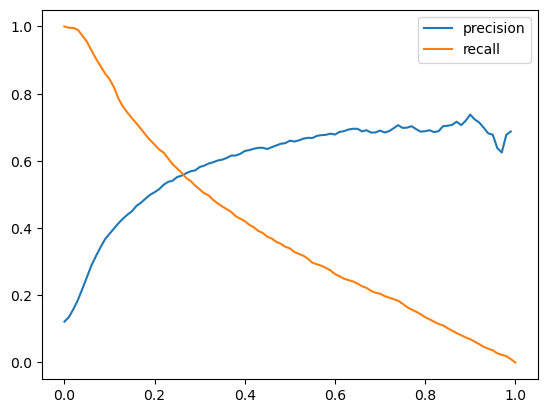

In [17]:
plt.plot(df_scores.threshold, df_scores.precision, label = "precision")
plt.plot(df_scores.threshold, df_scores.recall, label = "recall")

plt.legend()
plt.show()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- **0.22**
- 0.42
- 0.62

In [18]:
df_scores["f1_score"] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)
df_scores[::10]

,threshold,tp,tn,fp,fn,precision,recall,f1_score
0,0.0,1098,0,7945,0,0.121420,1.000000,0.216547
10,0.1,926,6452,1493,172,0.382803,0.843352,0.526585
20,0.2,712,7252,693,386,0.506762,0.648452,0.568917
30,0.3,566,7538,407,532,0.581706,0.515483,0.546596
40,0.4,462,7673,272,636,0.629428,0.420765,0.504367
50,0.5,373,7753,192,725,0.660177,0.339709,0.448587
60,0.6,289,7808,137,809,0.678404,0.263206,0.379265
70,0.7,225,7844,101,873,0.690184,0.204918,0.316011
80,0.8,148,7878,67,950,0.688372,0.134791,0.225438
90,0.9,76,7918,27,1022,0.737864,0.069217,0.126561


In [19]:
df_scores.loc[df_scores["f1_score"] == df_scores["f1_score"].max()]

,threshold,tp,tn,fp,fn,precision,recall,f1_score
22,0.22,686,7334,611,412,0.528913,0.624772,0.57286


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- **0.006**
- 0.06
- 0.26

In [20]:
def train(df_train, y_train, C=1):
    dicts = df_train[categorical + numerical].to_dict(orient = "records")

    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient = "records")

    X = dv.fit_transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
 
    y_train = df_train.y.values
    y_val = df_val.y.values
 
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
 
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(scores)
print("%.3f +- %.5f" % (np.mean(scores), np.std(scores)))

[0.9000379998658827, 0.8990203131901406, 0.9111601569466737, 0.9080148800731584, 0.91199007106869]
0.906 +- 0.00549


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- **1**

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.


In [21]:
for C in [0.000001, 0.001, 1]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
     
        y_train = df_train.y.values
        y_val = df_val.y.values
     
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
     
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print("C=%5s, %.3f +- %.3f" % (C, np.mean(scores), np.std(scores)))

C=1e-06, 0.701 +- 0.009
C=0.001, 0.861 +- 0.007
C=    1, 0.906 +- 0.005


## Submit the results

* Submit your results here: https://courses.datatalks.club/ml-zoomcamp-2024/homework/hw04
* If your answer doesn't match options exactly, select the closest one